# CROP-seq KO15 - DEA within condition between KOs & between conditions within KOs
- input: normalized data
- output: DEGs with log fold change and p-values, volcano plots, summary dot plot

In [1]:
# set correct working directory -> project folder
getwd()
setwd('..')
getwd()

[1] "/home/sreichl/projects/bmdm-stim/src"

[1] "/home/sreichl/projects/bmdm-stim"

In [2]:
# load libraries

# for Seurat (limma via conda install)
library(dplyr)
library(Seurat) # installed via conda install (conda forge channel)
library(patchwork)
library(ggplot2)
library(DESeq2)
library(cowplot)
library(glmGamPoi) # for faster sctransform

# for Upset plots
library(UpSetR)
library(fastDummies)

# for volcano plots
library(EnhancedVolcano)

library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, 

In [3]:
# configs
# mixscape_only <- FALSE
mixscape_only <- TRUE

if (mixscape_only){
    data_path <- file.path('results','KO15','unsupervised_mixscape')
    results_path <- file.path('results','KO15', 'DEA_condition_mixscape')
}else{
    data_path <- file.path('results','KO15')
    results_path <- file.path(data_path, 'DEA_condition')
}

In [4]:
# make directories if not exist
dir.create(results_path, showWarnings = FALSE)

# load data

In [4]:
# loading Seurat object
KO15 <-readRDS(file = file.path(data_path,paste0("KO15_normalized_Seurat.rds")))
KO15

An object of class Seurat 
44530 features across 4978 samples within 5 assays 
Active assay: SCT (13395 features, 3000 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 2 dimensional reductions calculated: pca, umap

## prepare metadata

In [5]:
KO15[['condition']] <- str_split_fixed(KO15$hto_demux, "_", 2)[,2]

# Violin plots for qualitative assessment of KOs

## plot antibody and gene expr alongside for CD115 vs CSF1R (sanity check)

In [7]:
DefaultAssay(KO15) <- 'SCT'

Saving 6.67 x 6.67 in image



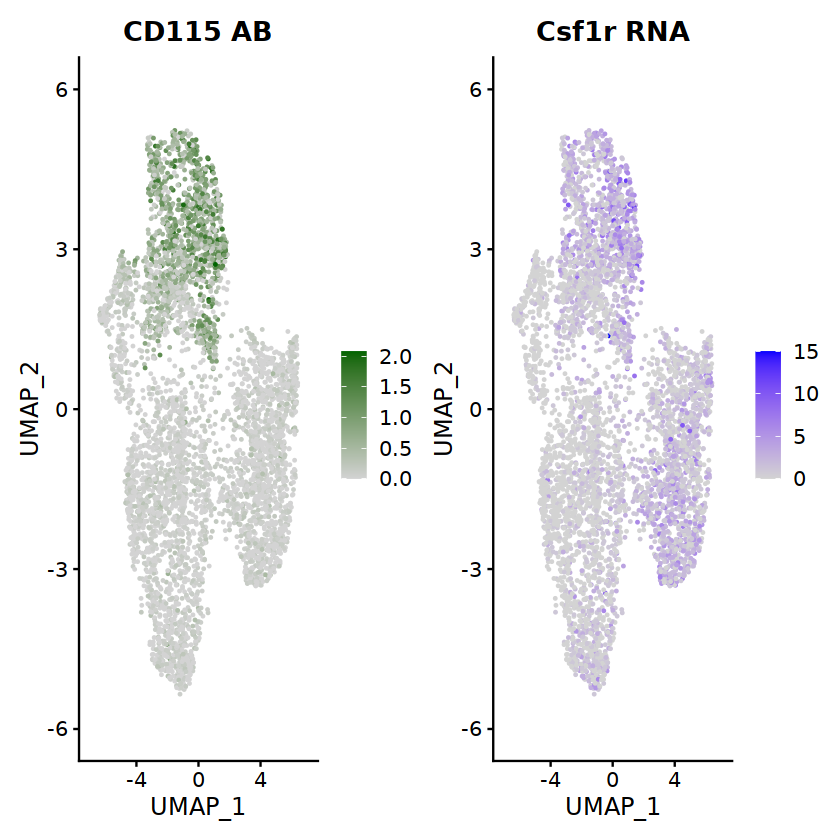

In [8]:
# plot umap of gene expr and Ab expression side by side
p1 <- FeaturePlot(KO15, "ab_CD115", cols = c("lightgrey", "darkgreen")) + ggtitle("CD115 AB")
p2 <- FeaturePlot(KO15, "rna_Csf1r") + ggtitle("Csf1r RNA")
p1 | p2
ggsave(
  paste0("KO15_",'umap',"_",'CD115_Csf1r_expression', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [9]:
# plot violinplot of gene expr and Ab expression side by side
for (feature in c("condition", "batch", "KO_call")){
    Idents(object = KO15) <- feature
    
    VlnPlot(KO15, features = c("ab_CD115", "rna_Csf1r"))
    
    ggsave(
      paste0("KO15_",'violin',"_",'CD115_Csf1r_expression_',feature, ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [10]:
Idents(object = KO15) <- "KO_call"

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.



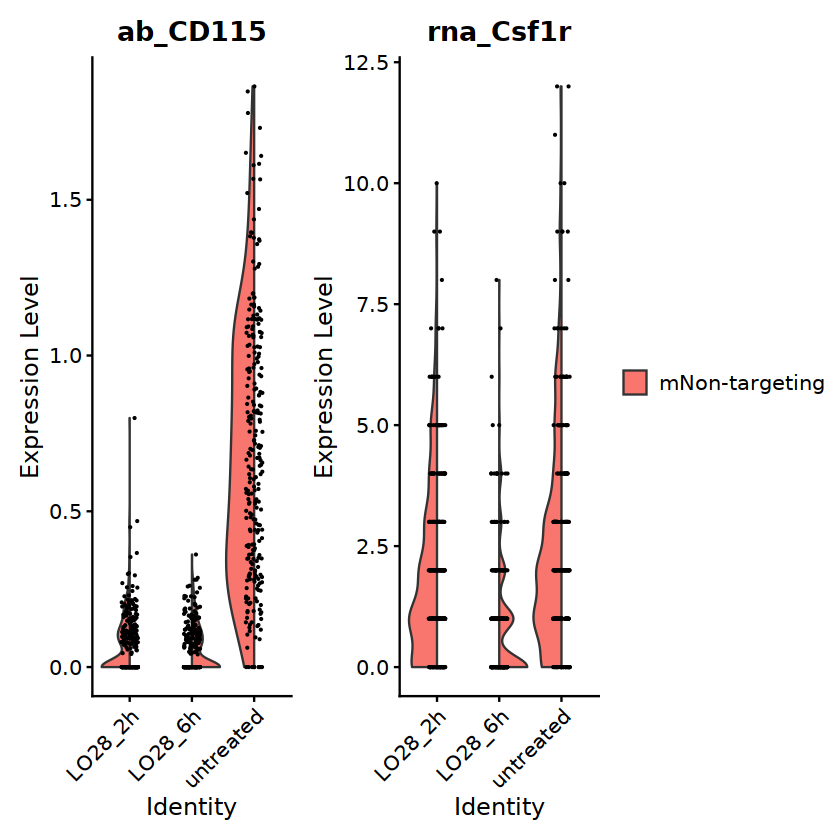

In [11]:
# violin plot only non-targeting vs mCsfr1 by conditions
p1 <- VlnPlot(KO15, 
        features = c("ab_CD115"), 
        idents=c( "mCsf1r", "mNon-targeting"), 
        split.by="KO_call", 
        group.by = "condition", 
        split.plot = TRUE
       ) + NoLegend()

p2 <- VlnPlot(KO15, 
        features = c("rna_Csf1r"), 
        idents=c("mCsf1r", "mNon-targeting"), 
        split.by="KO_call", 
        group.by = "condition", 
        split.plot = TRUE
       )

p3 <- p1 | p2

p3

ggsave(
  paste0("KO15_",'violin',"_",'CD115_Csf1r_by_condition', ".svg"),
  plot = p3,
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
    height=5,
    width=10
)

## violin plots non-targeting vs KO

In [12]:
# violin plots non-targeting vs KO
for (KO_gene in unique(KO15$KO_call)){
#     print(KO_gene)
    if (KO_gene=="mNon-targeting") {
        next
    }
    if (KO_gene=="mcJun") {
        next
    }
    VlnPlot(KO15, 
            features = paste0("rna_",substring(KO_gene, 2)), 
            idents=c("mNon-targeting", KO_gene), 
            split.by="KO_call", 
            group.by = "condition")
    
    ggsave(
      paste0("KO15_",'violin',"_expression_",KO_gene,'KO_by_condition', ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



Saving 6.67 x 6.67 in image



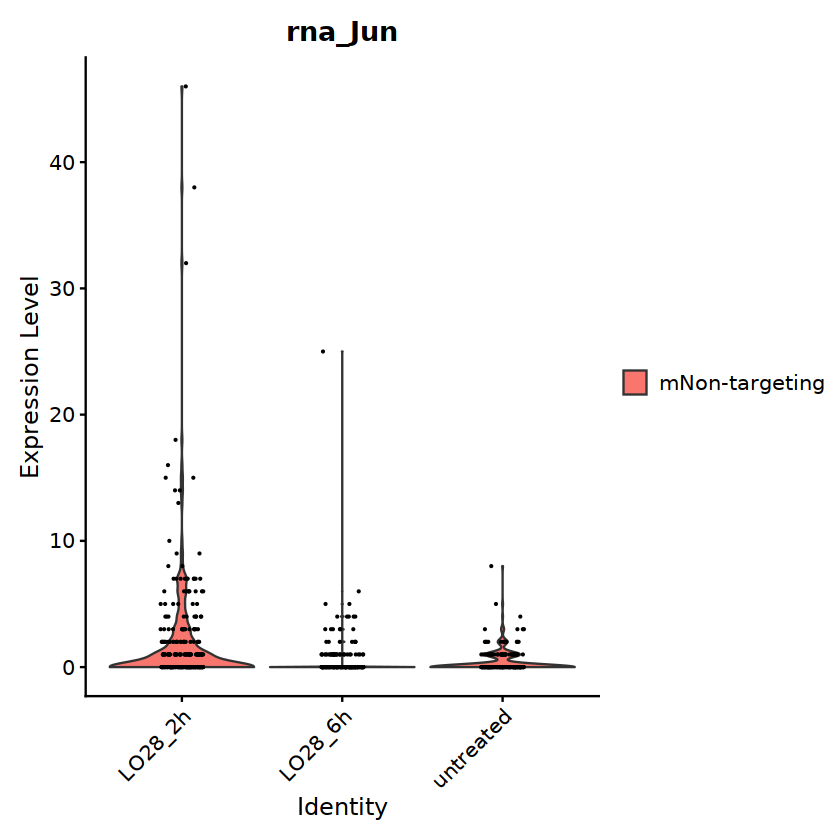

In [13]:
# special violin plot for non-targeting vs mJun KO with mcJun guide
KO_gene <- "mJun"
guide_gene <- "mcJun"

VlnPlot(KO15, 
        features = paste0("rna_",substring(KO_gene, 2)), 
        idents=c("mNon-targeting", guide_gene), 
        split.by="KO_call", 
        group.by = "condition")
    
ggsave(
  paste0("KO15_",'violin',"_expression_",KO_gene,'KO_by_condition', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

# DEA analysis within condition between KOs
https://satijalab.org/seurat/reference/findmarkers

In [6]:
KO15[["cond_KO"]] <- paste(KO15$condition,KO15$KO_call,sep="+")

In [7]:
Idents(object = KO15) <- "cond_KO"
levels(KO15)

[1] "LO28_2h+mStat1"           "LO28_2h+mIrf9"           
 [3] "LO28_2h+mNon-targeting"   "LO28_2h+mStat2"          
 [5] "LO28_2h+mRela"            "LO28_2h+mTyk2"           
 [7] "LO28_2h+mSpi1"            "LO28_2h+mEp300"          
 [9] "LO28_2h+mJak1"            "untreated+mStat1"        
[11] "untreated+mNon-targeting" "untreated+mIrf9"         
[13] "untreated+mStat2"         "untreated+mSpi1"         
[15] "untreated+mEp300"         "untreated+mJak1"         
[17] "untreated+mTyk2"          "LO28_6h+mNon-targeting"  
[19] "LO28_6h+mStat1"           "LO28_6h+mIrf9"           
[21] "LO28_6h+mEp300"           "LO28_6h+mIrf8"           
[23] "LO28_6h+mSpi1"            "LO28_6h+mRela"           
[25] "LO28_6h+mJak1"            "LO28_6h+mStat2"          
[27] "LO28_6h+mTyk2"

In [8]:
DefaultAssay(KO15)

[1] "SCT"

In [18]:
for (cond in unique(KO15$condition)){
    print(cond)
    
    for (KO_gene in unique(KO15$KO_call)){
        print(KO_gene)
        if ((KO_gene=="mNon-targeting")| (sum(KO15$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
        
        KO15.RNAmarkers <- FindMarkers(KO15, 
                                        only.pos = FALSE, 
                                        min.pct = 0.1, 
                                        logfc.threshold = 0.1, 
                                        test.use = "wilcox", 
                                        ident.1=paste(cond,KO_gene,sep='+'), 
                                        ident.2=paste(cond,"mNon-targeting",sep='+'), 
                                        random.seed=42
                                       )
        write.csv(KO15.RNAmarkers, 
                  file=file.path(results_path,paste0('KO15_DEA_RNA_',cond,'_',KO_gene,'.csv')), 
                  row.names=TRUE
                 )
        
        KO15.ABmarkers <- FindMarkers(KO15, 
                                       only.pos = FALSE, 
                                       min.pct = 0.1, 
                                       logfc.threshold = 0.1, 
                                       test.use = "wilcox", 
                                       assay = "AB", 
                                       ident.1=paste(cond,KO_gene,sep='+'), 
                                       ident.2=paste(cond,"mNon-targeting",sep='+'), 
                                       random.seed=42
                                      )
        write.csv(KO15.ABmarkers, 
                  file=file.path(results_path, paste0('KO15_DEA_AB_',cond,'_',KO_gene,'.csv')), 
                  row.names=TRUE
                 )
    }
}

[1] "LO28_2h"
[1] "mStat1"
[1] "mIrf9"
[1] "mNon-targeting"
[1] "mStat2"
[1] "mRela"
[1] "mTyk2"
[1] "mSpi1"
[1] "mEp300"
[1] "mJak1"
[1] "mIrf8"
[1] "untreated"
[1] "mStat1"
[1] "mIrf9"
[1] "mNon-targeting"
[1] "mStat2"
[1] "mRela"
[1] "mTyk2"
[1] "mSpi1"
[1] "mEp300"
[1] "mJak1"
[1] "mIrf8"
[1] "LO28_6h"
[1] "mStat1"
[1] "mIrf9"
[1] "mNon-targeting"
[1] "mStat2"
[1] "mRela"
[1] "mTyk2"
[1] "mSpi1"
[1] "mEp300"
[1] "mJak1"
[1] "mIrf8"


## Make summary tables of DEA results

In [19]:
# load DEA RNA results per condition, filter for sign. genes (<stat_sign), make table of number of sign. genes, up, down
stat_sign <- 0.05

for (pval in c('p_val_adj', 'p_val')){
    for (cond in unique(KO15$condition)){
        print(cond)

        tmp_df <- setNames(data.frame(matrix(ncol = 3, nrow = length(unique(KO15$KO_call)))), c("DEGs_n", "up", "down"))
        rownames(tmp_df) <- unique(KO15$KO_call)

        for (KO_gene in unique(KO15$KO_call)){
    #         print(KO_gene)
            if ((KO_gene=="mNon-targeting") | (sum(KO15$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
                next
            }

            tmp_dea_genes <- read.csv(file=file.path(results_path, paste0('KO15_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)

            if (pval=='p_val_adj'){
                stat_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign]
            }else{
                stat_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val<stat_sign]
            }
            
            up_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']>0)
            down_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']<0)

            tmp_df[KO_gene,] <- c(length(stat_genes),up_genes,down_genes)
        }
    #     print(tmp_df)
        write.csv(tmp_df, file=file.path(results_path, paste0('KO15_DEA_RNA_summary_',cond,'_',pval,'.csv')), row.names=TRUE)
    }
}

[1] "LO28_2h"
[1] "untreated"
[1] "LO28_6h"
[1] "LO28_2h"
[1] "untreated"
[1] "LO28_6h"


In [20]:
# load DEA AB results per condition, filter for sign. genes (adj.p-value<stat_sign), make table of number of sign. genes, up, down
stat_sign <- 0.05

for (pval in c('p_val_adj', 'p_val')){
    for (cond in unique(KO15$condition)){
        print(cond)

        tmp_df <- setNames(data.frame(matrix(ncol = 3, nrow = length(unique(KO15$KO_call)))), c("DEABs_n", "up", "down"))
        rownames(tmp_df) <- unique(KO15$KO_call)

        for (KO_gene in unique(KO15$KO_call)){
    #         print(KO_gene)
            if ((KO_gene=="mNon-targeting") | (sum(KO15$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
                next
            }

            tmp_dea_genes <- read.csv(file=file.path(results_path, paste0('KO15_DEA_AB_',cond,'_',KO_gene,'.csv')), row.names=1)

            if (pval=='p_val_adj'){
                stat_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign]
            }else{
                stat_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val<stat_sign]
            }
            
            up_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']>0)
            down_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']<0)

            tmp_df[KO_gene,] <- c(length(stat_genes),up_genes,down_genes)
        }
#         print(tmp_df)
        write.csv(tmp_df, file=file.path(results_path, paste0('KO15_DEA_AB_summary_',cond,'_',pval,'.csv')), row.names=TRUE)
    }
}

[1] "LO28_2h"
[1] "untreated"
[1] "LO28_6h"
[1] "LO28_2h"
[1] "untreated"
[1] "LO28_6h"


## heatmaps of top DEGs per condition
https://satijalab.org/seurat/reference/doheatmap

In [21]:
# load DEA results per condition, filter for sign. genes (adj.p-value<stat_sign), take union of top_n, make heatmap
top_n <- 10
stat_sign <- 0.05

for (cond in unique(KO15$condition)){
    print(cond)
    cond_genes <- vector()
    for (KO_gene in unique(KO15$KO_call)){
#         print(KO_gene)
        if ((KO_gene=="mNon-targeting") | (sum(KO15$cond_KO==paste(cond,KO_gene,sep='+'))==0))  {
            next
        }
        tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO15_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)
        cond_genes <- append(cond_genes, rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign][1:top_n])
    }
    
    DoHeatmap(KO15, cells=colnames(KO15)[KO15$condition==cond], group.by="KO_call", features = unique(cond_genes)) #+ NoLegend()
    
    ggsave(
      paste0("KO15_",'heatmap',"_DEA_RNA_",cond,"_top",top_n,"union.svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

[1] "LO28_2h"


Warning message in DoHeatmap(PT141, cells = colnames(PT141)[PT141$condition == cond], :
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: Coro1a”
Saving 6.67 x 6.67 in image



[1] "untreated"


Warning message in DoHeatmap(PT141, cells = colnames(PT141)[PT141$condition == cond], :
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: Fxyd5, Ybx1, Coro1a”
Saving 6.67 x 6.67 in image



[1] "LO28_6h"


Warning message in DoHeatmap(PT141, cells = colnames(PT141)[PT141$condition == cond], :
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: NA”
Saving 6.67 x 6.67 in image



## clustermap of DEA avgLFCs per condition (DEGs x DEA)

In [10]:
library(pheatmap)
library(ggplotify)

Warning message:
“package ‘pheatmap’ was built under R version 4.0.5”
Warning message:
“package ‘ggplotify’ was built under R version 4.0.5”


In [11]:
stat_sign <- 0.05

[1] 35.83515
[1] 36.34551


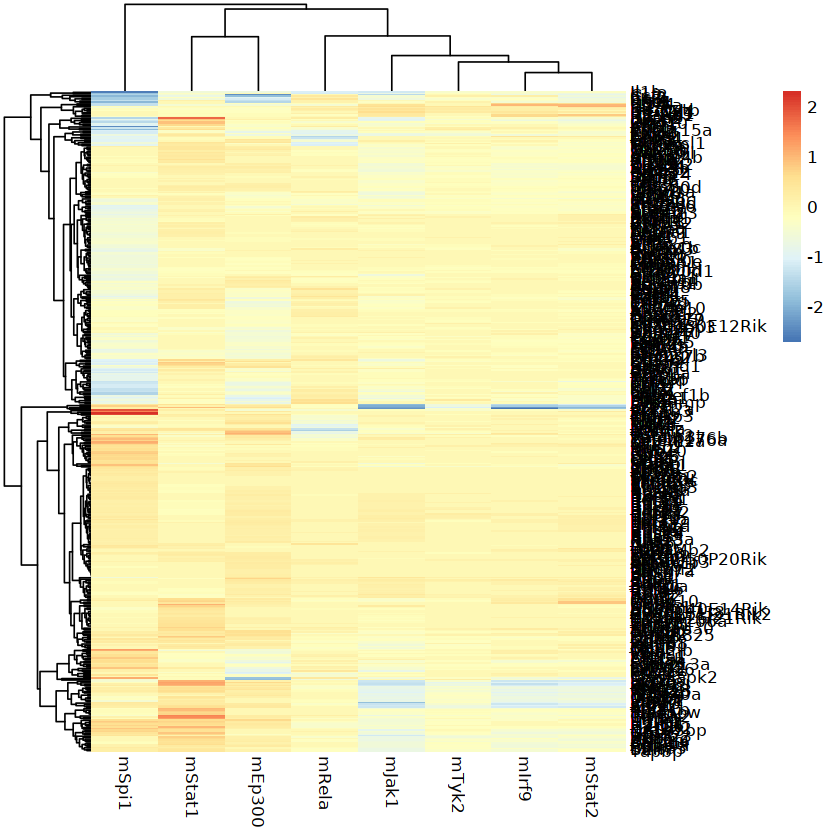

[1] 36.18597


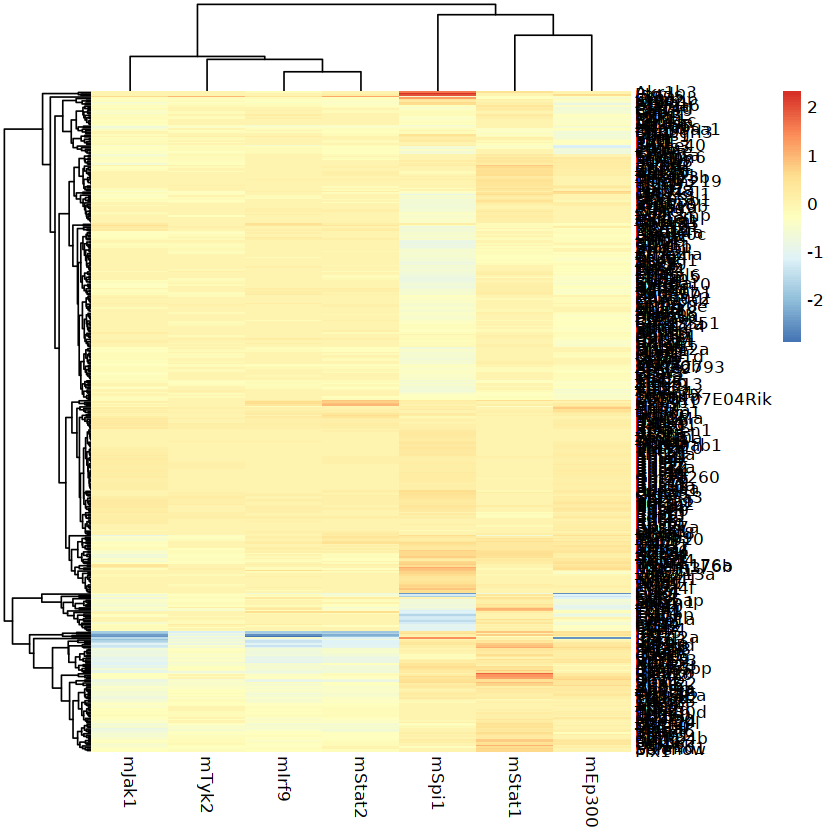

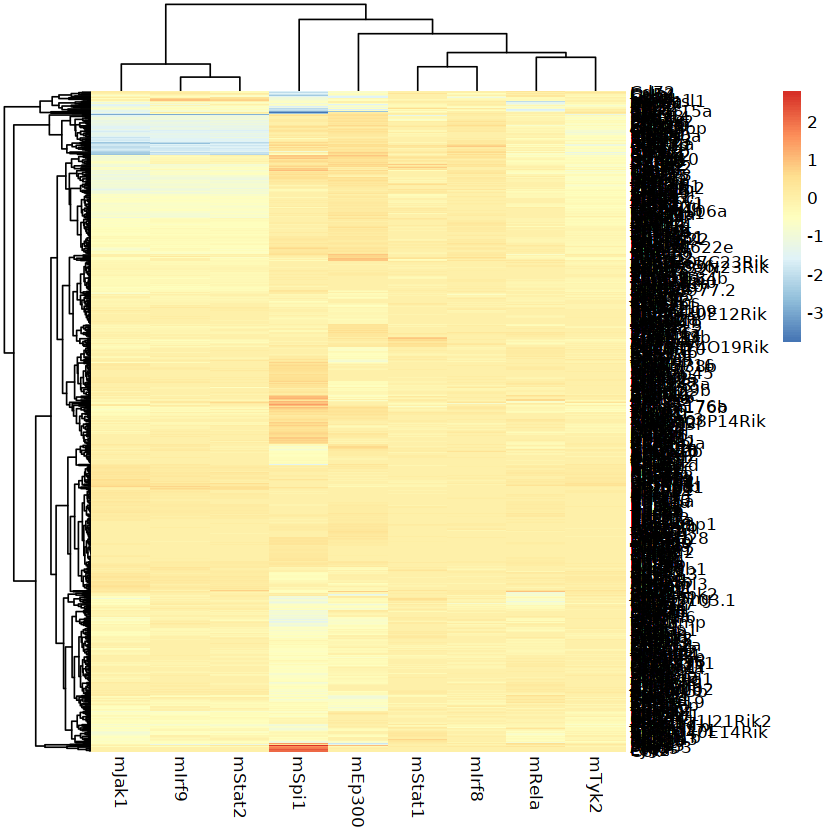

In [12]:
for (cond in unique(KO15$condition)){
    # make list of DEGs across all DEAs in a given condition
    cond_genes <- vector()
    for (KO_gene in unique(KO15$KO_call)){
    #         print(KO_gene)
            if ((KO_gene=="mNon-targeting")  | (sum(KO15$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
                next
            }
            tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO15_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)
            cond_genes <- append(cond_genes, rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign])
        }

    cond_genes <- unique(cond_genes)
    length(cond_genes)

    # make dataframe consisting of avg_log2FC of the identified DEGs
    DEG_LFC_df = data.frame(matrix(ncol=length(unique(KO15$KO_call[KO15$condition==cond]))-1,nrow=length(cond_genes), dimnames=list(cond_genes, unique(KO15$KO_call[KO15$condition==cond])[unique(KO15$KO_call[KO15$condition==cond])!='mNon-targeting'])))

    for (KO_gene in unique(KO15$KO_call)){
    #         print(KO_gene)
        if ((KO_gene=="mNon-targeting") | (sum(KO15$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
        tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO15_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)

        DEG_LFC_df[cond_genes,KO_gene] <- tmp_dea_genes[cond_genes,'avg_log2FC']
    }
    head(DEG_LFC_df)
    dim(DEG_LFC_df)

    print(sum(is.na(DEG_LFC_df))/(dim(DEG_LFC_df)[1]*dim(DEG_LFC_df)[2])*100)

    #save dataframe
    write.csv(DEG_LFC_df, file=file.path(results_path,paste0('KO15_DEA_RNA_LFC_',cond,'.csv')))
    
    # plot heatmap of LFC
    
    # impute NA with 0 -> actually just below 0.1 -> VALID???
    DEG_LFC_df[is.na(DEG_LFC_df)] <- 0

    width <- 20
    height <- 20

    tmp_plot <- as.ggplot(pheatmap(DEG_LFC_df))
    
    # save plot
    ggsave(
          paste0("KO15_",'clustermap',"_DEA_RNA_LFC_",cond,'.png'),
          plot = tmp_plot,
          device = 'png',
          path = file.path(results_path),
          scale = 1,
          dpi = 300,
            width = width,
            height = height,
          limitsize = FALSE,
        )
}

## clustermap of DEA AB avgLFCs per condition (DEPs x DEA)

In [9]:
library(pheatmap)
library(ggplotify)
library(tidyr)

Warning message:
“package ‘pheatmap’ was built under R version 4.0.5”
Warning message:
“package ‘ggplotify’ was built under R version 4.0.5”

Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand




In [10]:
stat_sign <- 0.05
width <- 5
height <- 5

In [11]:
# aggregate all DEA AB results
dea_ab_results <- data.frame()
for (cond in unique(KO15$condition)){
    for (KO_gene in unique(KO15$KO_call)){
        
        if ((KO_gene=="mNon-targeting")  | (sum(KO15$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
        
        tmp_dea_res <- read.csv(file=file.path(results_path,paste0('KO15_DEA_AB_',cond,'_',KO_gene,'.csv')), row.names=1)
        if (dim(tmp_dea_res)[1]==0){
            next
        }
        tmp_dea_res$ab <- rownames(tmp_dea_res)
        rownames(tmp_dea_res) <- NULL
        tmp_dea_res$group <- paste0(cond,'_',KO_gene)
        
        if(dim(dea_ab_results)[1]==0){
            dea_ab_results <- tmp_dea_res
        }else{
            dea_ab_results <- rbind(dea_ab_results, tmp_dea_res)
        }
    }
}

dim(dea_ab_results)
head(dea_ab_results)

[1] 103   7

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,ab,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,1.547594e-07,0.3901897,1,0.99,1.702353e-06,CD274,LO28_2h_mStat1
2,2.937996e-03,0.1577126,1,1.00,3.231796e-02,CD64,LO28_2h_mStat1
3,2.937996e-03,0.1959834,1,1.00,3.231796e-02,CD14,LO28_2h_mStat1
4,1.456659e-08,-0.2550945,1,1.00,1.602325e-07,CD64,LO28_2h_mIrf9
5,5.684699e-03,0.1828451,1,1.00,6.253169e-02,CD14,LO28_2h_mIrf9
6,2.493934e-09,-0.3245430,1,1.00,2.743327e-08,CD64,LO28_2h_mStat2


In [12]:
# make adjp dataframe for visualization of significance with *
dea_ab_results_adjp <- pivot_wider(dea_ab_results,id_cols='group', names_from='ab',  values_from = "p_val_adj", values_fill = 1)
dea_ab_results_adjp <- data.frame(dea_ab_results_adjp, row.names=dea_ab_results_adjp$group)
dea_ab_results_adjp$group <- NULL
mask <- dea_ab_results_adjp<stat_sign
dea_ab_results_adjp[mask] <- '*'
dea_ab_results_adjp[!mask] <- ' '
# dim(dea_ab_results_adjp)
# head(dea_ab_results_adjp)

In [13]:
# make LFC dataframe for visualization of effect size
dea_ab_results_lfc <- pivot_wider(dea_ab_results,id_cols='group', names_from='ab',  values_from = "avg_log2FC", values_fill = 0)
dea_ab_results_lfc <- data.frame(dea_ab_results_lfc, row.names=dea_ab_results_lfc$group)
dea_ab_results_lfc$group <- NULL
# dim(dea_ab_results_lfc)
# head(dea_ab_results_lfc)

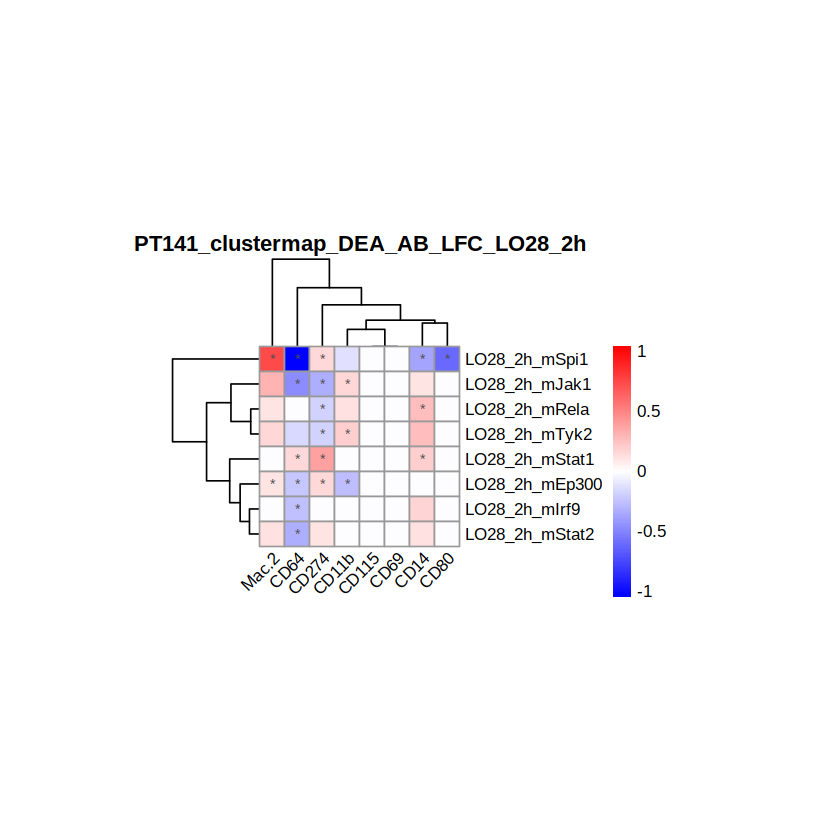

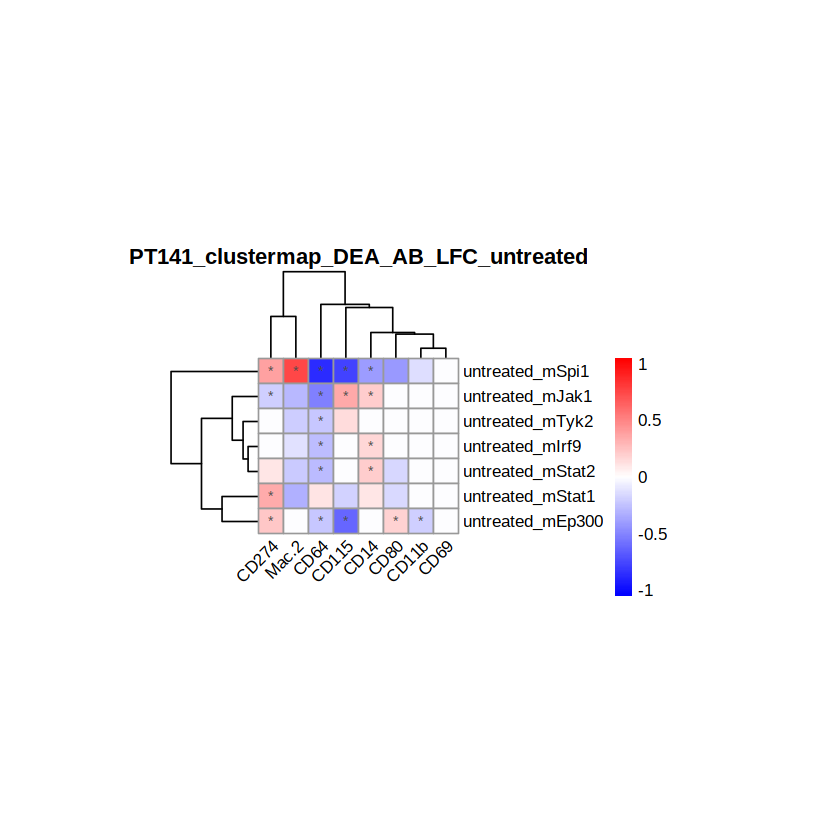

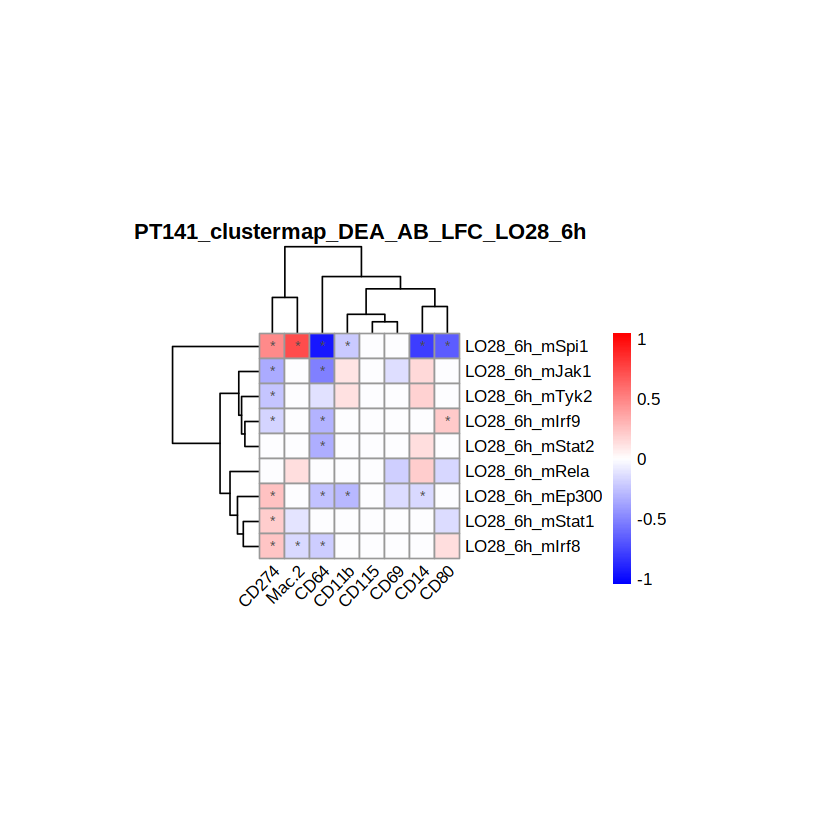

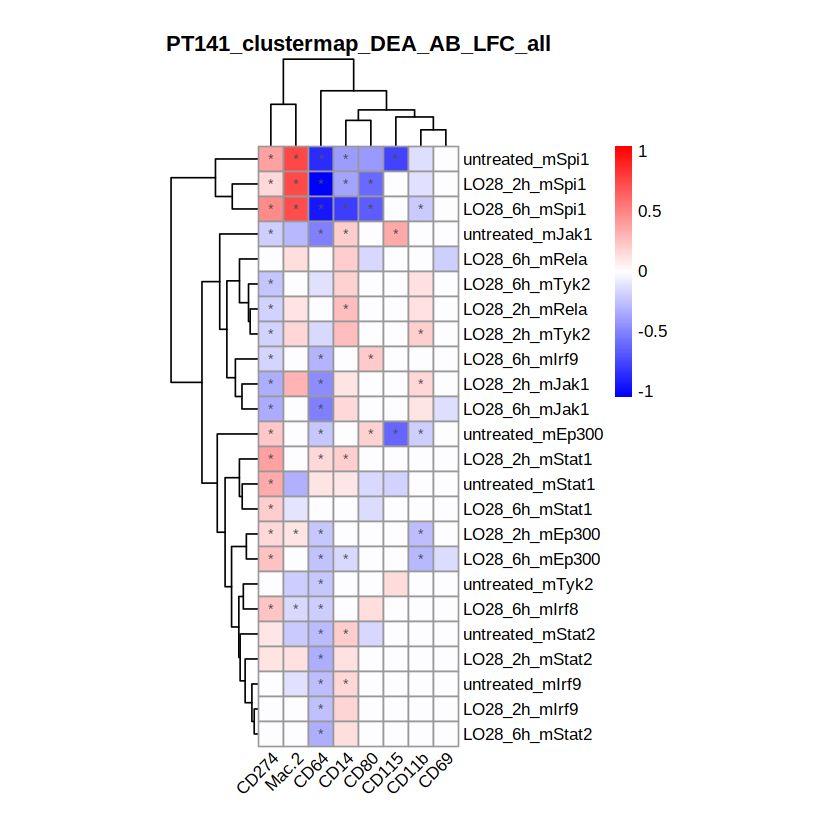

In [14]:
for (cond in c(unique(KO15$condition), 'all')){
    
    # select results
    if (cond=='all'){
        height <- 15
        tmp_lfc <- dea_ab_results_lfc
        tmp_adjp <- dea_ab_results_adjp
    }else{
        height <- 5
        tmp_idx <- grepl(cond, rownames(dea_ab_results_lfc), fixed = TRUE)
        tmp_lfc <- dea_ab_results_lfc[tmp_idx,]
        tmp_adjp <- dea_ab_results_adjp[tmp_idx,]
    }
    
    # plot and save heatmap
    tmp_plot <- as.ggplot(pheatmap(tmp_lfc,
             display_numbers=as.matrix(tmp_adjp),
                                   main = paste0("KO15_",'clustermap',"_DEA_AB_LFC_",cond),
             cellwidth = 15,
             cellheight = 15,
             angle_col = "45",
             breaks=seq(-max(abs(dea_ab_results_lfc)), max(abs(dea_ab_results_lfc)), length.out=200),
             color=colorRampPalette(c("blue", "white", "red"))(200)))

    # save plot
    ggsave(
          paste0("KO15_",'clustermap',"_DEA_AB_LFC_",cond,'.png'),
          plot = tmp_plot,
          device = 'png',
          path = file.path(results_path),
          scale = 1,
          dpi = 300,
            width = width,
            height = height,
          limitsize = FALSE,
        )
}

## dotplots of top DEGs per condition
https://satijalab.org/seurat/reference/dotplot

In [25]:
Idents(object = KO15) <- "condition"
levels(KO15)

[1] "LO28_2h"   "untreated" "LO28_6h"

In [26]:
# load DEA results per condition, filter for sign. genes (adj.p-value<stat_sign), take union of top_n, make dotplot
top_n <- 10
stat_sign <- 0.05
plot_dims <- 10

for (cond in unique(KO15$condition)){
#     print(cond)
    cond_genes <- vector()
    for (KO_gene in unique(KO15$KO_call)){
#         print(KO_gene)
        if ((KO_gene=="mNon-targeting") | (sum(KO15$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
        tmp_dea_genes <- read.csv(file=file.path(results_path, paste0('KO15_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)
        cond_genes <- append(cond_genes, rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign][1:top_n])
    }
    
    DotPlot(KO15, idents=c(cond), group.by="KO_call", features = unique(cond_genes))+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
    
    ggsave(
      paste0("KO15_",'dotplot',"_DEA_RNA_",cond,"_top",top_n,"union.svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
        height = plot_dims,
        width = plot_dims*length(unique(cond_genes))/length(unique(KO15$KO_call))
    )
}

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: NA”


## Volcano plots for DEA results

In [27]:
DefaultAssay(KO15)

[1] "SCT"

In [28]:
for (cond in unique(KO15$condition)){
#     print(cond)
    
    for (KO_gene in unique(KO15$KO_call)){
#         print(KO_gene)
        if ((KO_gene=="mNon-targeting")  | (sum(KO15$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
            next
        }
        
        RNA <- read.csv(file=file.path(results_path,paste0('KO15_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)

        AB <- read.csv(file=file.path(results_path,paste0('KO15_DEA_AB_',cond,'_',KO_gene,'.csv')), row.names=1)

        res <- rbind(RNA, AB)

        keyvals.shape <- ifelse(rownames(res)%in%rownames(AB), 17, 20)
        names(keyvals.shape)[keyvals.shape == 17]<-"AB"
        names(keyvals.shape)[keyvals.shape == 20]<-"RNA"

        EnhancedVolcano(
            res,
            lab = rownames(res),
            x = 'avg_log2FC',
            y = 'p_val_adj',
            title = cond,
            subtitle = paste0(KO_gene,' KO'),
            xlab=expression('average log'[2]*' fold change'),
            ylab=expression('-log'[10]*' adjusted p-value'),
            legendLabels=c('NS','avg.log2FC','adj.p-value', 'both'),
            pCutoff = 0.05,
            FCcutoff = 0.5,
            pointSize = 1.0,
            labSize = 3.0,
            colAlpha = 0.5,
            shapeCustom = keyvals.shape,
            legendPosition = 'right', #top, right, left, none
            caption = bquote("cutoffs avg." ~log[2]~ "FC 0.5; adj.p-value 0.05"),
        )

        ggsave(
          paste0("KO15_",'volcano',"_DEA_",cond,"_",KO_gene,".svg"),
          plot = last_plot(),
          device = "svg",
          path = file.path(results_path),
          scale = 1,
          dpi = 300,
          limitsize = FALSE,
        )
    }
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



## Enrichment plots for DEA results

In [29]:
# make directories if not exist
dir.create(file.path(results_path, 'enrichment_analysis'), showWarnings = FALSE)

In [30]:
DefaultAssay(KO15)

[1] "SCT"

In [31]:
library(enrichR)

Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is available!

WormEnrichr ... 
Connection is available!

YeastEnrichr ... 
Connection is available!

FishEnrichr ... 
Connection is available!



In [32]:
# parameters for testing
# cond <- 'untreated'
# KO_gene <- 'Stat1'
# enrich.database <- 'KEGG_2019_Mouse' #'GO_Biological_Process_2021'  'KEGG_2019_Mouse' 'WikiPathways_2019_Mouse'

In [33]:
# parameters for enrichment plots
p_val_metric <- 'p_val_adj' # 'p_val_adj' 'p_val'
p.val.cutoff <- 0.05
num.pathway <- 25
cols <- NULL
balanced <- TRUE

In [47]:
for (enrich.database in c('GO_Biological_Process_2021','KEGG_2019_Mouse','WikiPathways_2019_Mouse')){
    for (cond in unique(KO15$condition)){
    #     print(cond)

        for (KO_gene in unique(KO15$KO_call)){
    #         print(KO_gene)
            if ((KO_gene=="mNon-targeting") | (sum(KO15$cond_KO==paste(cond,KO_gene,sep='+'))==0)) {
                next
            }
            all.markers <- read.csv(file=file.path(results_path,paste0('KO15_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)

            pos.markers <- all.markers[all.markers[, 2] > 0 & all.markers[, p_val_metric] < p.val.cutoff, , drop = FALSE]
            neg.markers <- all.markers[all.markers[, 2] < 0 & all.markers[, p_val_metric] < p.val.cutoff, , drop = FALSE]

            gene.list <- list()
            pos.er <- list()
            neg.er <- list()
            
            if(nrow(pos.markers) == 0){
                message("No positive markers pass the logfc.thershold")
              }else{
                pos.markers.list <- rownames(x = pos.markers)[1:nrow(x = pos.markers)]
                pos.er <- enrichR::enrichr(genes = pos.markers.list, databases = enrich.database)
                pos.er <- do.call(what = cbind, args = pos.er)
                pos.er$log10pval <- -log10(x = pos.er[, paste(enrich.database, sep = ".", "P.value")])
                pos.er$term <- pos.er[, paste(enrich.database, sep = ".", "Term")]
                pos.er <- pos.er[1:num.pathway, ]
                pos.er$term <- factor(x = pos.er$term, levels = pos.er$term[order(pos.er$log10pval)])
                gene.list <- list(pos = pos.er)
            }
            if(nrow(neg.markers) == 0){
                message("No negative markers pass the logfc.thershold")
            }else{
                neg.markers.list <- rownames(x = neg.markers)[1:nrow(x = neg.markers)]
                neg.er <- enrichR::enrichr(genes = neg.markers.list, databases = enrich.database)
                neg.er <- do.call(what = cbind, args = neg.er)
                neg.er$log10pval <- -log10(x = neg.er[, paste(enrich.database, sep = ".", "P.value")])
                neg.er$term <- neg.er[, paste(enrich.database, sep = ".", "Term")]
                neg.er <- neg.er[1:num.pathway, ]
                neg.er$term <- factor(x = neg.er$term, levels = neg.er$term[order(neg.er$log10pval)])
                gene.list <- list(neg = neg.er)
            }

            if(length(gene.list) == 0){
                stop("No positive or negative marker genes identified")
                next
            }else{
                if(isTRUE(length(neg.er$term) == 0)){

                    gene.list <- list(pos = pos.er)

                }
                else{
                  gene.list <- list(pos = pos.er, neg = neg.er)
                }
            }

              if(nrow(pos.markers) == 0){
                message("No positive markers to plot")

                if (isTRUE(x = balanced)) {

                  p2 <- ggplot(data = neg.er, aes_string(x = "term", y = "log10pval")) +
                    geom_bar(stat = "identity", fill = "indianred2") +
                    coord_flip() + xlab("Pathway") +
                    scale_fill_manual(values = cols, drop = FALSE) +
                    ylab(paste0("-log10(",p_val_metric,")")) +
                    ggtitle(paste(enrich.database, KO_gene, sep = "_", "negative markers")) +
                    theme_classic() +
                    geom_text(aes_string(label = "term", y = 0),
                              size = 3,
                              color = "black",
                              position = position_dodge(1),
                              hjust = 0)+
                    theme(axis.title.y= element_blank(),
                          axis.text.y = element_blank(),
                          axis.ticks.y = element_blank())
                  p <- p2

                }else{
                    stop("Nothing to plot")
                    next
                }
              }else {
              p <- ggplot(data = pos.er, aes_string(x = "term", y = "log10pval")) +
                geom_bar(stat = "identity", fill = "dodgerblue") +
                coord_flip() + xlab("Pathway") +
                scale_fill_manual(values = cols, drop = FALSE) +
                ylab(paste0("-log10(",p_val_metric,")")) +
                ggtitle(paste(enrich.database, KO_gene, sep = "\n", "positive markers")) +
                theme_classic() +
                geom_text(aes_string(label = "term", y = 0),
                          size = 3,
                          color = "black",
                          position = position_dodge(1),
                          hjust = 0)+
                theme(axis.title.y= element_blank(),
                      axis.text.y = element_blank(),
                      axis.ticks.y = element_blank())
              if (isTRUE(x = balanced) & length(neg.er)!=0) {

                p2 <- ggplot(data = neg.er, aes_string(x = "term", y = "log10pval")) +
                  geom_bar(stat = "identity", fill = "indianred2") +
                  coord_flip() + xlab("Pathway") +
                  scale_fill_manual(values = cols, drop = FALSE) +
                  ylab(paste0("-log10(",p_val_metric,")")) +
                  ggtitle(paste(enrich.database, KO_gene, sep = "\n", "negative markers")) +
                  theme_classic() +
                  geom_text(aes_string(label = "term", y = 0),
                            size = 3,
                            color = "black",
                            position = position_dodge(1),
                            hjust = 0)+
                  theme(axis.title.y= element_blank(),
                        axis.text.y = element_blank(),
                        axis.ticks.y = element_blank())
                p <- p+p2

              }
              }

            ggsave(
              paste0("KO15_",'enrichment',"_DEA_",cond,"_",KO_gene,"_",enrich.database,".svg"),
              plot = p,
              device = "svg",
              path = file.path(results_path, 'enrichment_analysis'),
              scale = 1,
              dpi = 300,
              limitsize = FALSE,
            )
        }
    }
}

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


No negative markers pass the logfc.thershold

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 4 rows containing missing values (position_stack).”
Warning message:
“Removed 4 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


No negative markers pass the logfc.thershold

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 21 rows containing missing values (position_stack).”
Warning message:
“Removed 21 rows containing missing values (geom_text).”
No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 20 rows containing missing values (position_stack).”
Warning message:
“Removed 20 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 25 rows containing missing values (position_stack).”
Warning message:
“Removed 25 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 6 rows containing missing values (position_stack).”
Warning message:
“Removed 6 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 21 rows containing missing values (position_stack).”
Warning message:
“Removed 21 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 5 rows containing missing values (position_stack).”
Warning message:
“Removed 5 rows containing missing values (geom_text).”
Warning message:
“Removed 24 rows containing missing values (position_stack).”
Warning message:
“Removed 24 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


No negative markers pass the logfc.thershold

Saving 6.67 x 6.67 in image

Warning message:
“Removed 6 rows containing missing values (position_stack).”
Warning message:
“Removed 6 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”
Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 21 rows containing missing values (position_stack).”
Warning message:
“Removed 21 rows containing missing values (geom_text).”
Warning message:
“Removed 2 rows containing missing values (position_stack).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 24 rows containing missing values (position_stack).”
Warning message:
“Removed 24 rows containing missing values (geom_text).”
No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image

Warning message:
“Removed 22 rows containing missing values (position_stack).”
Warning message:
“Removed 22 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 9 rows containing missing values (position_stack).”
Warning message:
“Removed 9 rows containing missing values (geom_text).”
Warning message:
“Removed 9 rows containing missing values (position_stack).”
Warning message:
“Removed 9 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 19 rows containing missing values (position_stack).”
Warning message:
“Removed 19 rows containing missing values (geom_text).”
Warning message:
“Removed 12 rows containing missing values (position_stack).”
Warning message:
“Removed 12 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 13 rows containing missing values (position_stack).”
Warning message:
“Removed 13 rows containing missing values (geom_text).”
Warning message:
“Removed 14 rows containing missing values (position_stack).”
Warning message:
“Removed 14 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 25 rows containing missing values (position_stack).”
Warning message:
“Removed 25 rows containing missing values (geom_text).”
Warning message:
“Removed 22 rows containing missing values (position_stack).”
Warning message:
“Removed 22 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 14 rows containing missing values (position_stack).”
Warning message:
“Removed 14 rows containing missing values (geom_text).”
Warning message:
“Removed 3 rows containing missing values (position_stack).”
Warning message:
“Removed 3 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 9 rows containing missing values (position_stack).”
Warning message:
“Removed 9 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 15 rows containing missing values (position_stack).”
Warning message:
“Removed 15 rows containing missing values (geom_text).”
No positive markers pass the logfc.thershold



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


No positive markers to plot

Saving 6.67 x 6.67 in image

Warning message:
“Removed 8 rows containing missing values (position_stack).”
Warning message:
“Removed 8 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 23 rows containing missing values (position_stack).”
Warning message:
“Removed 23 rows containing missing values (geom_text).”
Warning message:
“Removed 11 rows containing missing values (position_stack).”
Warning message:
“Removed 11 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image



Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 5 rows containing missing values (position_stack).”
Warning message:
“Removed 5 rows containing missing values (geom_text).”


Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


Saving 6.67 x 6.67 in image

Warning message:
“Removed 24 rows containing missing values (position_stack).”
Warning message:
“Removed 24 rows containing missing values (geom_text).”
Warning message:
“Removed 24 rows containing missing values (position_stack).”
Warning message:
“Removed 24 rows containing missing values (geom_text).”


# DEA analysis within KOs between conditions
https://satijalab.org/seurat/reference/findmarkers

In [13]:
# make directories if not exist
if (mixscape_only){
    results_path <- file.path('results','KO15', 'DEA_KO_mixscape')
}else{
    results_path <- file.path(data_path, 'DEA_KO')
}

dir.create(file.path(results_path), showWarnings = FALSE)

In [14]:
KO15[["cond_KO"]] <- paste(KO15$condition,KO15$KO_call,sep="+")

In [15]:
Idents(object = KO15) <- "cond_KO"
levels(KO15)

[1] "LO28_2h+mStat1"           "LO28_2h+mIrf9"           
 [3] "LO28_2h+mNon-targeting"   "LO28_2h+mStat2"          
 [5] "LO28_2h+mRela"            "LO28_2h+mTyk2"           
 [7] "LO28_2h+mSpi1"            "LO28_2h+mEp300"          
 [9] "LO28_2h+mJak1"            "untreated+mStat1"        
[11] "untreated+mNon-targeting" "untreated+mIrf9"         
[13] "untreated+mStat2"         "untreated+mSpi1"         
[15] "untreated+mEp300"         "untreated+mJak1"         
[17] "untreated+mTyk2"          "LO28_6h+mNon-targeting"  
[19] "LO28_6h+mStat1"           "LO28_6h+mIrf9"           
[21] "LO28_6h+mEp300"           "LO28_6h+mIrf8"           
[23] "LO28_6h+mSpi1"            "LO28_6h+mRela"           
[25] "LO28_6h+mJak1"            "LO28_6h+mStat2"          
[27] "LO28_6h+mTyk2"

In [16]:
# manually reorder for correct DEA order (newer vs older)
conditions <- unique(KO15$condition)[c(2,1,3)]
conditions

[1] "untreated" "LO28_2h"   "LO28_6h"

In [17]:
DefaultAssay(KO15)

[1] "SCT"

In [53]:
for (KO_gene in unique(KO15$KO_call)){
#     print(KO_gene)
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
            print(paste(cond1,cond2))
            
            if ((sum(KO15$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO15$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
            # RNA
            KO15.RNAmarkers <- FindMarkers(KO15, 
                                            only.pos = FALSE, 
                                            min.pct = 0.1, 
                                            logfc.threshold = 0.1, 
                                            test.use = "wilcox", 
                                            ident.1=paste(cond2,KO_gene,sep='+'), 
                                            ident.2=paste(cond1,KO_gene,sep='+'), 
                                            random.seed=42)
            write.csv(KO15.RNAmarkers, file=file.path(results_path,paste0('KO15_DEA_RNA_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=TRUE)

            # AB
            KO15.ABmarkers <- FindMarkers(KO15, 
                                           only.pos = FALSE, 
                                           min.pct = 0.1, 
                                           logfc.threshold = 0.1, 
                                           test.use = "wilcox",
                                           assay = "AB", 
                                           ident.1=paste(cond2,KO_gene,sep='+'), 
                                           ident.2=paste(cond1,KO_gene,sep='+'), 
                                           random.seed=42)
            write.csv(KO15.ABmarkers, file=file.path(results_path,paste0('KO15_DEA_AB_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=TRUE)
        }
    }
}

[1] "untreated LO28_2h"
[1] "untreated LO28_6h"
[1] "LO28_2h LO28_6h"
[1] "untreated LO28_2h"
[1] "untreated LO28_6h"
[1] "LO28_2h LO28_6h"
[1] "untreated LO28_2h"
[1] "untreated LO28_6h"
[1] "LO28_2h LO28_6h"
[1] "untreated LO28_2h"
[1] "untreated LO28_6h"
[1] "LO28_2h LO28_6h"
[1] "untreated LO28_2h"
[1] "untreated LO28_6h"
[1] "LO28_2h LO28_6h"
[1] "untreated LO28_2h"
[1] "untreated LO28_6h"
[1] "LO28_2h LO28_6h"
[1] "untreated LO28_2h"
[1] "untreated LO28_6h"
[1] "LO28_2h LO28_6h"
[1] "untreated LO28_2h"
[1] "untreated LO28_6h"
[1] "LO28_2h LO28_6h"
[1] "untreated LO28_2h"
[1] "untreated LO28_6h"
[1] "LO28_2h LO28_6h"
[1] "untreated LO28_2h"
[1] "untreated LO28_6h"
[1] "LO28_2h LO28_6h"


## summary tables of DEA within KO between condition results

In [54]:
conditions <- unique(KO15$condition)[c(2,1,3)]
conditions

[1] "untreated" "LO28_2h"   "LO28_6h"

In [55]:
# load all DEA RNA results per KO, filter for sign. genes (adj.p-value<stat_sign), make table of number of sign. genes, up, down
stat_sign <- 0.05

for (KO_gene in unique(KO15$KO_call)){
    print(KO_gene)
    
    tmp_df <- setNames(data.frame(matrix(ncol = 3, nrow =0)), c("DEGs_n", "up", "down"))
    
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
#             print(paste(cond1,cond2))
            
            if ((sum(KO15$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO15$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
            
            tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO15_DEA_RNA_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)

            stat_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign]
            up_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']>0)
            down_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']<0)

            tmp_df[paste0(cond2,'_VS_',cond1),] <- c(length(stat_genes),up_genes,down_genes)
        }
    }
#     print(tmp_df)
    write.csv(tmp_df, file=file.path(results_path,paste0('KO15_DEA_RNA_summary_',KO_gene,'.csv')), row.names=TRUE)
}

[1] "mStat1"
[1] "mIrf9"
[1] "mNon-targeting"
[1] "mStat2"
[1] "mRela"
[1] "mTyk2"
[1] "mSpi1"
[1] "mEp300"
[1] "mJak1"
[1] "mIrf8"


In [56]:
# load all DEA AB results per KO, filter for sign. genes (adj.p-value<stat_sign), make table of number of sign. genes, up, down
stat_sign <- 0.05

for (KO_gene in unique(KO15$KO_call)){
    print(KO_gene)
    
    tmp_df <- setNames(data.frame(matrix(ncol = 3, nrow =0)), c("DEABs_n", "up", "down"))
    
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
#             print(paste(cond1,cond2))
            
            if ((sum(KO15$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO15$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
            
            tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO15_DEA_AB_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)

            stat_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign]
            up_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']>0)
            down_genes <- sum(tmp_dea_genes[stat_genes,'avg_log2FC']<0)

            tmp_df[paste0(cond2,'_VS_',cond1),] <- c(length(stat_genes),up_genes,down_genes)
        }
    }
#     print(tmp_df)
    write.csv(tmp_df, file=file.path(results_path,paste0('KO15_DEA_AB_summary_',KO_gene,'.csv')), row.names=TRUE)
}

[1] "mStat1"
[1] "mIrf9"
[1] "mNon-targeting"
[1] "mStat2"
[1] "mRela"
[1] "mTyk2"
[1] "mSpi1"
[1] "mEp300"
[1] "mJak1"
[1] "mIrf8"


## heatmaps of top DEGs per KO
https://satijalab.org/seurat/reference/doheatmap

In [57]:
# load DEA results per KO gene, filter for sign. genes (adj.p-value<stat_sign), take union of top_n, make heatmap
top_n <- 10
stat_sign <- 0.05
plot_dims <- 10

for (KO_gene in unique(KO15$KO_call)){
#     print(KO_gene)
    KO_genes <- vector()
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
#             print(paste(cond1,cond2))
            if ((sum(KO15$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO15$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
            
            tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO15_DEA_RNA_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)
            KO_genes <- append(KO_genes, rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign][1:top_n])
        }
    }
    
    if (length(unique(KO_genes))==0){
        next
    }
    if (is.na(unique(KO_genes))){
        next
    }
    
    DoHeatmap(KO15, cells=colnames(KO15)[KO15$KO_call==KO_gene], group.by="condition", features = unique(KO_genes),  size = 3, angle=90) + NoLegend()
    
    ggsave(
      paste0("KO15_",'heatmap',"_DEA_RNA_",KO_gene,"_top",top_n,"union.svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
        height = plot_dims,#*length(unique(cond_genes))/length(unique(PT149$KO_call)),
        width = plot_dims
    )
}

Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (i

## clustermap of DEA avgLFCs per condition (DEGs x DEA)

In [18]:
library(pheatmap)
library(ggplotify)

In [19]:
stat_sign <- 0.05

[1] 2412

,mStat1_LO28_2h_untreated,mStat1_LO28_6h_untreated,mStat1_LO28_6h_LO28_2h,mIrf9_LO28_2h_untreated,mIrf9_LO28_6h_untreated,mIrf9_LO28_6h_LO28_2h,mNon-targeting_LO28_2h_untreated,mNon-targeting_LO28_6h_untreated,mNon-targeting_LO28_6h_LO28_2h,mStat2_LO28_2h_untreated,⋯,mTyk2_LO28_6h_LO28_2h,mSpi1_LO28_2h_untreated,mSpi1_LO28_6h_untreated,mSpi1_LO28_6h_LO28_2h,mEp300_LO28_2h_untreated,mEp300_LO28_6h_untreated,mEp300_LO28_6h_LO28_2h,mJak1_LO28_2h_untreated,mJak1_LO28_6h_untreated,mJak1_LO28_6h_LO28_2h
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Junb,2.908315,1.140399,-1.7679162,3.099997,1.1049925,-1.9950043,3.075966,1.508593,-1.5673738,2.810549,⋯,-1.8838865,2.804290,1.1935417,-1.6107478,2.771205,1.487855,-1.2833496,3.208565,1.0966986,-2.1118665
Tnf,4.323990,3.249607,-1.0743824,4.467034,3.3311414,-1.1358922,4.583788,3.697620,-0.8861679,4.380846,⋯,-1.0520189,3.377732,2.6360696,-0.7416625,3.848838,3.166165,-0.6826728,4.225024,2.8546778,-1.3703465
Nfkbiz,2.766163,1.902567,-0.8635956,2.697571,1.9287734,-0.7687973,2.753887,1.849692,-0.9041945,2.750672,⋯,-0.8861766,2.192455,1.3527633,-0.8396912,2.808276,1.429812,-1.3784640,2.559217,1.4341463,-1.1250708
Zfp36,3.616161,1.283229,-2.3329318,2.968696,0.9292712,-2.0394247,3.159040,1.481330,-1.6777099,2.856880,⋯,-1.9309842,2.384230,0.5243312,-1.8598987,3.191971,1.476276,-1.7156959,2.529382,0.4878783,-2.0415036
Ccl4,3.551351,3.326327,-0.2250235,4.459434,3.3200353,-1.1393986,4.757866,3.835236,-0.9226293,4.975805,⋯,-0.7998708,4.445303,3.5023666,-0.9429362,4.899335,4.408007,-0.4913283,5.113297,3.3287396,-1.7845577
Ier3,2.939979,1.689281,-1.2506982,2.464358,1.8341282,-0.6302299,2.923477,2.025487,-0.8979898,2.939917,⋯,-1.1430291,2.638693,1.3906386,-1.2480548,2.736300,1.276895,-1.4594045,2.736733,2.0345633,-0.7021694


[1] 2412   25

[1] 30.82753


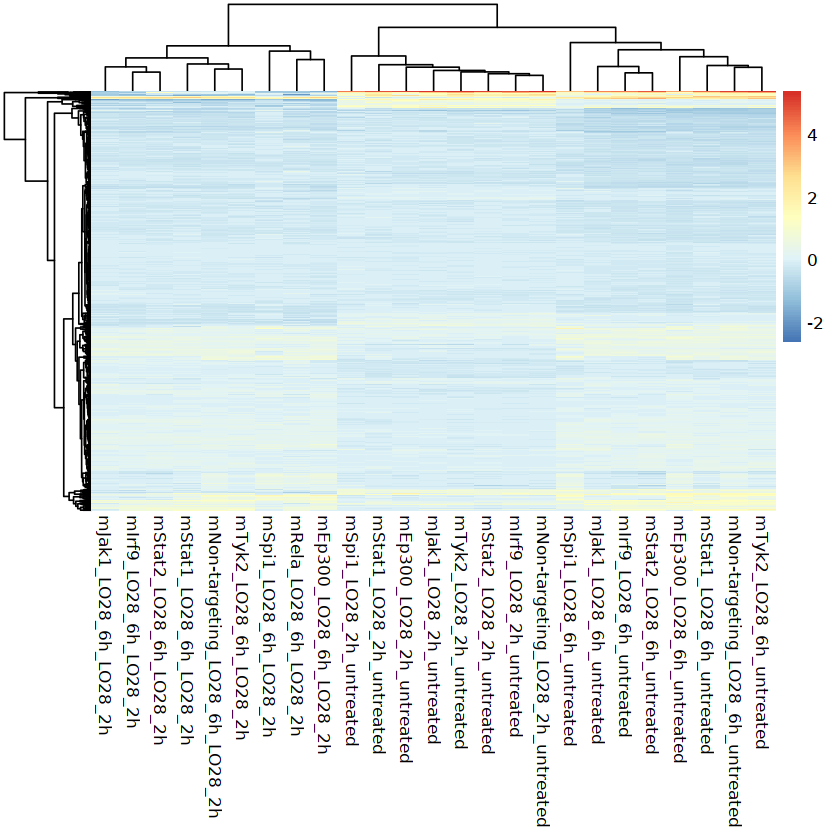

In [21]:
KO_genes <- vector()

for (KO_gene in unique(KO15$KO_call)){
#     print(KO_gene)
    
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
#             print(paste(cond1,cond2))
            if ((sum(KO15$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO15$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
            
            tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO15_DEA_RNA_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)
            KO_genes <- append(KO_genes, rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign])
        }
    }
}

KO_genes <- unique(KO_genes)
length(KO_genes)

# make dataframe consisting of avg_log2FC of the identified DEGs
DEG_LFC_df = data.frame(matrix(ncol=0,nrow=length(KO_genes), dimnames=list(KO_genes, c())))

for (KO_gene in unique(KO15$KO_call)){
#     print(KO_gene)
    
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
#             print(paste(cond1,cond2))
            if ((sum(KO15$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO15$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
            
            tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO15_DEA_RNA_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)
            DEG_LFC_df[KO_genes,paste0(KO_gene,'_',cond2,'_',cond1)] <- tmp_dea_genes[KO_genes,'avg_log2FC']
        }
    }
}

head(DEG_LFC_df)
dim(DEG_LFC_df)

print(sum(is.na(DEG_LFC_df))/(dim(DEG_LFC_df)[1]*dim(DEG_LFC_df)[2])*100)

#save dataframe
write.csv(DEG_LFC_df, file=file.path(results_path,paste0('KO15_DEA_KO_RNA_LFC.csv')))
    
# plot heatmap of LFC

# impute NA with 0 -> actually just below 0.1 -> VALID???
DEG_LFC_df[is.na(DEG_LFC_df)] <- 0

width <- 20
height <- 20

tmp_plot <- as.ggplot(pheatmap(DEG_LFC_df, show_rownames=FALSE))

# save plot
ggsave(
      paste0("KO15_",'clustermap',"_DEA_KO_RNA_LFC.png"),
      plot = tmp_plot,
      device = 'png',
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
        width = width,
        height = height,
      limitsize = FALSE,
    )

## dotplots of top DEGs per KO
https://satijalab.org/seurat/reference/dotplot

In [58]:
Idents(object = KO15) <- "KO_call"
levels(KO15)

[1] "mStat1"         "mIrf9"          "mNon-targeting" "mStat2"        
 [5] "mRela"          "mTyk2"          "mSpi1"          "mEp300"        
 [9] "mJak1"          "mIrf8"

In [59]:
# load DEA results per KO gene, filter for sign. genes (adj.p-value<stat_sign), take union of top_n, make dotplot
top_n <- 10
stat_sign <- 0.05
plot_dims <- 10

for (KO_gene in unique(KO15$KO_call)){
#     print(KO_gene)
    KO_genes <- vector()
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
#             print(paste(cond1,cond2))
            if ((sum(KO15$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO15$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
          
            tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO15_DEA_RNA_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)
            KO_genes <- append(KO_genes, rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign][1:top_n])
        }
    }
    
    if (length(unique(KO_genes))==0){
        next
    }
    if (is.na(unique(KO_genes))){
        next
    }
    
    DotPlot(KO15, idents=c(KO_gene), group.by="condition", features = unique(KO_genes))+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
    
    ggsave(
      paste0("KO15_",'dotplot',"_DEA_RNA_",KO_gene,"_top",top_n,"union.svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
        height = 5,#plot_dims*length(unique(KO_genes))/length(unique(PT149$condition)),
        width = plot_dims
    )
}

Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(unique(KO_genes))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (i

## Volcano plots for DEA results per KO

In [60]:
DefaultAssay(KO15)

[1] "SCT"

In [61]:
for (KO_gene in unique(KO15$KO_call)){
#     print(KO_gene)
    KO_genes <- vector()
    for (cond1 in conditions[-length(conditions)]){
        for (cond2 in conditions[(match(cond1,conditions)+1):length(conditions)]){
#             print(paste(cond1,cond2))
            
            if ((sum(KO15$cond_KO==paste(cond1,KO_gene,sep='+'))==0) | (sum(KO15$cond_KO==paste(cond2,KO_gene,sep='+'))==0)) {
                next
            }
        
            RNA <- read.csv(file=file.path(results_path,paste0('KO15_DEA_RNA_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)

            AB <- read.csv(file=file.path(results_path,paste0('KO15_DEA_AB_',KO_gene,'_',cond2,'_',cond1,'.csv')), row.names=1)

            res <- rbind(RNA, AB)

            keyvals.shape <- ifelse(rownames(res)%in%rownames(AB), 17, 20)# before 17,1
            names(keyvals.shape)[keyvals.shape == 17]<-"AB"
            names(keyvals.shape)[keyvals.shape == 20]<-"RNA"

            EnhancedVolcano(
                res,
                lab = rownames(res),
                x = 'avg_log2FC',
                y = 'p_val_adj',
                title = KO_gene,
                subtitle = paste0(cond2,' VS ',cond1),
                xlab=expression('average log'[2]*' fold change'),
                ylab=expression('-log'[10]*' adjusted p-value'),
                legendLabels=c('NS','avg.log2FC','adj.p-value', 'both'),
                pCutoff = 0.05,
                FCcutoff = 0.5,
                pointSize = 1.0,
                labSize = 3.0,
                colAlpha = 0.5,
                shapeCustom = keyvals.shape,
                legendPosition = 'right', #top, right, left, none
                caption = bquote("cutoffs avg." ~log[2]~ "FC 0.5; adj.p-value 0.05"),
            )

            ggsave(
              paste0("KO15_",'volcano',"_DEA_",KO_gene,'_',cond2,'_',cond1,".svg"),
              plot = last_plot(),
              device = "svg",
              path = file.path(results_path),
              scale = 1,
              dpi = 300,
              limitsize = FALSE,
            )
        }
    }
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



# Downsampling experiments

In [85]:
# make directories if not exist
results_path <- file.path(data_path,"DEA_downsampling")
dir.create(file.path(results_path), showWarnings = FALSE)

In [88]:
Idents(object = KO15) <- "cond_KO"
levels(KO15)

[1] "LO28_2h+mStat1"           "untreated+mIrf8"         
 [3] "untreated+mKdm1b"         "LO28_6h+mNon-targeting"  
 [5] "LO28_6h+mHdac6"           "LO28_2h+mIrf9"           
 [7] "LO28_6h+mStat1"           "LO28_2h+mNon-targeting"  
 [9] "LO28_6h+mTyk2"            "untreated+mStat1"        
[11] "LO28_2h+mcJun"            "LO28_2h+mStat2"          
[13] "untreated+mNon-targeting" "LO28_6h+mIrf9"           
[15] "LO28_6h+mIrf8"            "LO28_6h+mEp300"          
[17] "untreated+mIrf9"          "LO28_2h+mKdm6b"          
[19] "untreated+mStat2"         "LO28_6h+mCsf1r"          
[21] "LO28_2h+mRela"            "untreated+mSpi1"         
[23] "LO28_6h+mSpi1"            "LO28_6h+mCreb1"          
[25] "LO28_2h+mTyk2"            "untreated+mEp300"        
[27] "untreated+mRela"          "untreated+mHdac6"        
[29] "untreated+mTyk2"          "untreated+mKdm6b"        
[31] "LO28_6h+mRela"            "LO28_6h+mKdm1b"          
[33] "LO28_2h+mSpi1"            "LO28_6h+mJak1"           
[35] "LO28_2h+mEp300"           "LO28_2h+mCsf1r"          
[37] "LO28_2h+mKdm1b"           "untreated+mCsf1r"        
[39] "LO28_6h+mKdm6b"           "untreated+mJak1"         
[41] "LO28_6h+mStat2"           "LO28_2h+mCreb1"          
[43] "LO28_2h+mJak1"            "untreated+mCreb1"        
[45] "LO28_2h+mIrf8"            "LO28_6h+mcJun"           
[47] "LO28_2h+mHdac6"           "untreated+mcJun"

In [89]:
for (maxcells in c(200, 100, 50, 25)){
    for (cond in unique(KO15$condition)){
        print(cond)

        for (KO_gene in unique(KO15$KO_call)){
            print(KO_gene)
            if (KO_gene=="mNon-targeting") {
                next
            }

            KO15.RNAmarkers <- FindMarkers(KO15, only.pos = FALSE, min.pct = 0.1, logfc.threshold = 0.1, test.use = "wilcox", ident.1=paste(cond,KO_gene,sep='+'), ident.2=paste(cond,"mNon-targeting",sep='+'), max.cells.per.ident=maxcells, random.seed=42)
            write.csv(KO15.RNAmarkers, file=file.path(results_path,paste0('KO15_DEA_RNA_',cond,'_',KO_gene,'_',maxcells,'.csv')), row.names=TRUE)

            KO15.ABmarkers <- FindMarkers(KO15, only.pos = FALSE, min.pct = 0.1, logfc.threshold = 0.1, test.use = "wilcox", assay = "AB", ident.1=paste(cond,KO_gene,sep='+'), ident.2=paste(cond,"mNon-targeting",sep='+'), max.cells.per.ident=maxcells, random.seed=42)
            write.csv(KO15.ABmarkers, file=file.path(results_path,paste0('KO15_DEA_AB_',cond,'_',KO_gene,'_',maxcells,'.csv')), row.names=TRUE)
        }
    }
}

[1] "LO28_2h"
[1] "mStat1"
[1] "mIrf8"
[1] "mKdm1b"


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
“No features pass logfc.threshold threshold; returning empty data.frame”


[1] "mNon-targeting"
[1] "mHdac6"
[1] "mIrf9"
[1] "mTyk2"
[1] "mcJun"
[1] "mStat2"
[1] "mEp300"
[1] "mKdm6b"
[1] "mCsf1r"


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
“No features pass logfc.threshold threshold; returning empty data.frame”


[1] "mRela"
[1] "mSpi1"
[1] "mCreb1"
[1] "mJak1"
[1] "untreated"
[1] "mStat1"
[1] "mIrf8"
[1] "mKdm1b"
[1] "mNon-targeting"
[1] "mHdac6"
[1] "mIrf9"
[1] "mTyk2"
[1] "mcJun"
[1] "mStat2"
[1] "mEp300"
[1] "mKdm6b"
[1] "mCsf1r"
[1] "mRela"
[1] "mSpi1"
[1] "mCreb1"
[1] "mJak1"
[1] "LO28_6h"
[1] "mStat1"
[1] "mIrf8"
[1] "mKdm1b"
[1] "mNon-targeting"
[1] "mHdac6"
[1] "mIrf9"
[1] "mTyk2"
[1] "mcJun"
[1] "mStat2"
[1] "mEp300"
[1] "mKdm6b"
[1] "mCsf1r"
[1] "mRela"
[1] "mSpi1"
[1] "mCreb1"
[1] "mJak1"
[1] "LO28_2h"
[1] "mStat1"
[1] "mIrf8"
[1] "mKdm1b"


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
“No features pass logfc.threshold threshold; returning empty data.frame”


[1] "mNon-targeting"
[1] "mHdac6"
[1] "mIrf9"
[1] "mTyk2"
[1] "mcJun"
[1] "mStat2"
[1] "mEp300"
[1] "mKdm6b"
[1] "mCsf1r"


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
“No features pass logfc.threshold threshold; returning empty data.frame”


[1] "mRela"
[1] "mSpi1"
[1] "mCreb1"
[1] "mJak1"
[1] "untreated"
[1] "mStat1"
[1] "mIrf8"
[1] "mKdm1b"
[1] "mNon-targeting"
[1] "mHdac6"
[1] "mIrf9"
[1] "mTyk2"
[1] "mcJun"
[1] "mStat2"
[1] "mEp300"
[1] "mKdm6b"
[1] "mCsf1r"
[1] "mRela"
[1] "mSpi1"
[1] "mCreb1"
[1] "mJak1"
[1] "LO28_6h"
[1] "mStat1"
[1] "mIrf8"
[1] "mKdm1b"
[1] "mNon-targeting"
[1] "mHdac6"
[1] "mIrf9"
[1] "mTyk2"
[1] "mcJun"
[1] "mStat2"
[1] "mEp300"
[1] "mKdm6b"
[1] "mCsf1r"
[1] "mRela"
[1] "mSpi1"
[1] "mCreb1"
[1] "mJak1"
[1] "LO28_2h"
[1] "mStat1"
[1] "mIrf8"
[1] "mKdm1b"


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
“No features pass logfc.threshold threshold; returning empty data.frame”


[1] "mNon-targeting"
[1] "mHdac6"
[1] "mIrf9"
[1] "mTyk2"
[1] "mcJun"
[1] "mStat2"
[1] "mEp300"
[1] "mKdm6b"
[1] "mCsf1r"


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
“No features pass logfc.threshold threshold; returning empty data.frame”


[1] "mRela"
[1] "mSpi1"
[1] "mCreb1"
[1] "mJak1"
[1] "untreated"
[1] "mStat1"
[1] "mIrf8"
[1] "mKdm1b"
[1] "mNon-targeting"
[1] "mHdac6"
[1] "mIrf9"
[1] "mTyk2"
[1] "mcJun"
[1] "mStat2"
[1] "mEp300"
[1] "mKdm6b"
[1] "mCsf1r"
[1] "mRela"
[1] "mSpi1"
[1] "mCreb1"
[1] "mJak1"
[1] "LO28_6h"
[1] "mStat1"
[1] "mIrf8"
[1] "mKdm1b"
[1] "mNon-targeting"
[1] "mHdac6"
[1] "mIrf9"
[1] "mTyk2"
[1] "mcJun"
[1] "mStat2"
[1] "mEp300"
[1] "mKdm6b"
[1] "mCsf1r"
[1] "mRela"
[1] "mSpi1"
[1] "mCreb1"
[1] "mJak1"
[1] "LO28_2h"
[1] "mStat1"
[1] "mIrf8"
[1] "mKdm1b"


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
“No features pass logfc.threshold threshold; returning empty data.frame”


[1] "mNon-targeting"
[1] "mHdac6"
[1] "mIrf9"
[1] "mTyk2"
[1] "mcJun"
[1] "mStat2"
[1] "mEp300"
[1] "mKdm6b"
[1] "mCsf1r"


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
“No features pass logfc.threshold threshold; returning empty data.frame”


[1] "mRela"
[1] "mSpi1"
[1] "mCreb1"
[1] "mJak1"
[1] "untreated"
[1] "mStat1"
[1] "mIrf8"
[1] "mKdm1b"
[1] "mNon-targeting"
[1] "mHdac6"
[1] "mIrf9"
[1] "mTyk2"
[1] "mcJun"
[1] "mStat2"
[1] "mEp300"
[1] "mKdm6b"
[1] "mCsf1r"
[1] "mRela"
[1] "mSpi1"
[1] "mCreb1"
[1] "mJak1"
[1] "LO28_6h"
[1] "mStat1"
[1] "mIrf8"
[1] "mKdm1b"
[1] "mNon-targeting"
[1] "mHdac6"
[1] "mIrf9"
[1] "mTyk2"
[1] "mcJun"
[1] "mStat2"
[1] "mEp300"
[1] "mKdm6b"
[1] "mCsf1r"
[1] "mRela"
[1] "mSpi1"
[1] "mCreb1"
[1] "mJak1"


In [90]:
# generate summary tables and quantify the overlap with the full DEA list (new column overlap)
# load DEA RNA results per condition, filter for sign. genes (adj.p-value<stat_sign), make table of number of sign. genes, up, down
stat_sign <- 0.05
cell_n <-c(200, 100, 50, 25)

for (cond in unique(KO15$hto_demux)){
    print(cond)
    
    tmp_df <- setNames(data.frame(matrix(ncol = 6, nrow = length(unique(KO15$KO_call))*(length(cell_n)))), c("DEGs_n","overlap_DEGs_n", "up","overlap_up", "down", "overlap_down"))
    rownames(tmp_df) <- sort(do.call(paste, c(expand.grid(unique(KO15$KO_call), c(cell_n)), list(sep='_'))))
    
    for (KO_gene in unique(KO15$KO_call)){
#         print(KO_gene)
        if (KO_gene=="mNon-targeting") {
            next
        }
    
        tmp_dea_genes <- read.csv(file=file.path(results_path,paste0('KO15_DEA_RNA_',cond,'_',KO_gene,'.csv')), row.names=1)

        stat_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign]
        up_genes <- stat_genes[tmp_dea_genes[stat_genes,'avg_log2FC']>0]
        down_genes <- stat_genes[tmp_dea_genes[stat_genes,'avg_log2FC']<0]
        
        tmp_cell_count <- sum(KO15$hto_demux==cond & KO15$KO_call==KO_gene)
        
        tmp_df[paste0(KO_gene,'_',tmp_cell_count),] <- c(length(stat_genes),
                                             length(stat_genes),
                                             length(up_genes),
                                             length(up_genes),
                                             length(down_genes),
                                             length(down_genes)
                                            )
        
        for (maxcells in cell_n){
            # load DEA results for that maxcell parameter
            dea_genes_sampled <- read.csv(file=file.path(results_path,paste0('KO15_DEA_RNA_',cond,'_',KO_gene,'_',maxcells,'.csv')), row.names=1)
            
            # determine stat genes
            stat_genes_sampled <- rownames(dea_genes_sampled)[dea_genes_sampled$p_val_adj<stat_sign]
            up_genes_sampled <- stat_genes_sampled[dea_genes_sampled[stat_genes_sampled,'avg_log2FC']>0]
            down_genes_sampled <- stat_genes_sampled[dea_genes_sampled[stat_genes_sampled,'avg_log2FC']<0]
            
            # determine overlap
            stat_genes_overlap <- sum(stat_genes_sampled %in% stat_genes)
            up_genes_overlap <- sum(up_genes_sampled %in% up_genes)
            down_genes_overlap <- sum(down_genes_sampled %in% down_genes)
            
            tmp_df[paste0(KO_gene,'_',maxcells),] <- c(length(stat_genes_sampled),
                                                       stat_genes_overlap,
                                                       length(up_genes_sampled),
                                                       up_genes_overlap,
                                                       length(down_genes_sampled),
                                                       down_genes_overlap
                                                      )
        }
    }
    tmp_df$cell_counts<-as.numeric(str_split_fixed(rownames(tmp_df), '_',2)[,2])
    tmp_df$KO_gene<-str_split_fixed(rownames(tmp_df), '_',2)[,1]
    tmp_df <- tmp_df[, c('KO_gene', 'cell_counts',"DEGs_n","overlap_DEGs_n", "up","overlap_up", "down", "overlap_down")]
    tmp_df <- tmp_df[with(tmp_df, order(KO_gene, -cell_counts)), ]
    
#     print(tmp_df)
    write.csv(tmp_df, file=file.path(results_path,paste0('KO15_DEA_RNA_summary_',cond,'.csv')), row.names=TRUE)
}

[1] "HTO-RAW-SZ_LO28_2h"


Warning message in file(file, "rt"):
“cannot open file 'results/PT141/DEA_downsampling/PT141_DEA_RNA_HTO-RAW-SZ_LO28_2h_mStat1.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection
